本次对比学习实验以pytorch作为基础框架。

In [12]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

定义多个用于存储信息的超参数
    device：模型运行所在设备
    batch_size：批样本大小
    loss_list: 损失函数列表
    transform: 数据加载过程中对数据进行处理的方法
通过torch中包含的数据集加载方式加载MNIST数据集

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
loss_list = []

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

train_data = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='../data', train=False, transform=transform, download=True)
epochs = 25
learning_rate = 3e-3

定义函数以获取数据集中对应的数据用于构建自定义数据集

In [14]:
def get_data(dataset):
    x_data, y_data = [], []
    for i in range(len(dataset)):
        x, y = dataset[i]
        x_data.append(x)
        y_data.append(y)
    return x_data, y_data

定义了一个自定义的数据集类 my_dataset，继承自 PyTorch 的 Dataset 类，主要用于从给定的输入数据和标签数据中创建一个数据集对象。
    获取数据样本
        根据给定的索引，从输入数据和标签数据中提取相应的样本 x 和标签 y。
        随机生成两个索引 idx1 和 idx2，分别用于选择与当前样本 x 具有相同标签和不同标签的样本。
        使用 while 循环确保 idx1 处的样本与当前样本标签 y 相同，而 idx2 处的样本标签与 y 不同。
        最终返回一个包含三个样本和一个标签的元组，即当前样本 x、与 x 标签相同的样本、与 x 标签不同的样本和标签 y。

In [15]:
class my_dataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        possibility = np.random.rand()
        idx1 = np.random.randint(0, len(self.y_data) - 1)
        idx2 = np.random.randint(0, len(self.y_data) - 1)
        while self.y_data[idx1] != y:
            idx1 = np.random.randint(0, len(self.y_data) - 1)
        while self.y_data[idx2] == y:
            idx2 = np.random.randint(0, len(self.y_data) - 1)
        return x, self.x_data[idx1],self.x_data[idx2],y

通过函数加载数据集中的数据后，创建自定义数据集的实例并放入DataLoader中用于训练/测试

In [16]:
train_x_data, train_y_data = get_data(train_data)
test_x_data, test_y_data = get_data(test_data)
train_dataset = my_dataset(train_x_data, train_y_data)
test_dataset = my_dataset(test_x_data, test_y_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

构建孪生神经网络（Siamese类）用于对比学习任务
-    网络结构
-    卷积层和激活函数：
-    第一层：nn.Conv2d(1, 4, kernel_size=3, padding=1, stride=1) 和 nn.ReLU()。
-    第二层：nn.Conv2d(4, 8, kernel_size=3, padding=1, stride=1) 和 nn.ReLU()。
-    第三层：nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=1) 和 nn.ReLU()。
-    第四层：nn.Conv2d(16, 4, kernel_size=3, padding=1, stride=1) 和 nn.ReLU()。
-    批量归一化层：
-    在每个卷积层后面，都有相应的批量归一化层：nn.BatchNorm2d(4), nn.BatchNorm2d(8), nn.BatchNorm2d(16), nn.BatchNorm2d(4)。
-    扁平化层：
-    nn.Flatten()：将多维的卷积输出展平为一维。
-    Dropout层：
-    nn.Dropout(0.2)：防止过拟合。
-    全连接层：
-    nn.Linear(3136, out_features=4096)：将展平后的特征映射到一个高维空间。

In [17]:
class Siamese(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.Conv2d(4, 8, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 1, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(784, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, out_features=2)
        )

    def forward(self, x):
        x = self.features(x)
        return x

定义三元组损失函数
    输入一个包括锚示例、正示例、负示例的数据三元组，通过优化锚示例与正示例的距离小于锚示例与负示例的距离，实现样本之间的相似性计算。
    计算公式如下：
        $L = max(d(a,p)-d(a,n)+margin,0)$


In [18]:
def triplet_loss(anchor, positive, negative, margin):
    distance_positive = F.pairwise_distance(anchor, positive, p=2)
    distance_negative = F.pairwise_distance(anchor, negative, p=2)
    losses = F.relu(distance_positive - distance_negative + margin)
    return losses.mean()

定义名为AutoEDcoder的类实现了一个卷积神经网络编码器部分，用于从输入图像中提取高维特征表示
-    编码器结构
-    卷积层和激活函数：
-    第一层：nn.Conv2d输入通道为1，输出通道为3，卷积核大小为3，步幅为2，填充为1。
-    第二层：nn.Conv2d输入通道为3，输出通道为9，卷积核大小为3，步幅为2，填充为1。
-    第三层：nn.Conv2d输入通道为9，输出通道为18，卷积核大小为3，步幅为2，填充为1。
-    批量归一化层：
-    在每个卷积层后面，都有相应的批量归一化层：nn.BatchNorm2d(3), nn.BatchNorm2d(9), nn.BatchNorm2d(18)。
-    激活函数：
-    每个批量归一化层后面，跟着一个 LeakyReLU 激活函数：nn.LeakyReLU()。
-    扁平化层：
-    nn.Flatten()：将多维的卷积输出展平为一维。
-    全连接层：
-    nn.Linear(18 * 4 * 4, 512)：将展平后的特征映射到一个 512 维的空间。
-    nn.Linear(512, 1024)：进一步将特征映射到一个 1024 维的空间。

In [19]:
class AutoEDcoder(nn.Module):
    def __init__(self):
        super(AutoEDcoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(),
            nn.Conv2d(3, 9, 3, 2, 1),
            nn.BatchNorm2d(9),
            nn.LeakyReLU(),
            nn.Conv2d(9, 18, 3, 2, 1),
            nn.BatchNorm2d(18),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(18 * 4 * 4, 2),
        )

    def forward(self, x):
        # Encoder
        code = self.encoder(x)
        return code

定义函数用于训练相关模型
    在训练过程中，首先确保模型、数据位于同一个设备，然后通过在每个epoch中遍历整个训练数据集，并通过梯度下降进行优化，以此完成模型的训练。
    同时在训练过程中，在每个epoch训练结束时输出并记录该epoch总损失值，用于后续的模型性能评估。

In [20]:
def train(model, train_loader, optimizer, epochs, device):
    model = model.to(device)
    for epoch in range(epochs):
        total_loss = 0
        for i, (x1, x2, x3, y) in enumerate(train_loader):
            x1, x2, x3,y = x1.to(device), x2.to(device), x3.to(device),y.to(device)
            pred1 = model(x1)
            pred2 = model(x2)
            pred3 = model(x3)
            loss = triplet_loss(pred1, pred2, pred3,margin=3)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.detach().cpu().numpy()
        loss_list.append(total_loss)
        print(f'epoch:{epoch + 1} total_loss:{total_loss}')

eval函数用于评估相关的模型性能
    评估方式如下：
        模型设置与训练损失绘制：
            设置模型为评估模式，以禁用Dropout层等在训练模式下的功能。
            使用matplotlib库绘制训练过程中记录的损失值，展示损失随训练周期（epochs）的变化趋势。
        2D t-SNE可视化：
            使用t-SNE算法将高维数据降维到二维。
            遍历测试数据集，将数据传递给模型并获取预测结果。
            对预测结果进行t-SNE降维，并对结果进行标准化处理。
            在2D图像中绘制降维后的数据点，并为每个数据点着色，以反映其标签值。

In [21]:
def eval(model, device, test_loader, epochs):
    model = model.to(device)
    model.eval()
    x = [i for i in range(epochs)]
    plt.plot(x, loss_list)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    encoded_features = []  
    original_labels = []  
    with torch.no_grad():
        for data in test_loader:
            anchor_imgs, _, _, labels = data
            anchor_imgs = anchor_imgs.to(device)
            anchor_outputs = model(anchor_imgs)
    
            encoded_features.extend(anchor_outputs.cpu().numpy())
            original_labels.extend(labels.cpu().numpy())
    
            if len(encoded_features) >= 7000:
                break
    encoded_features = np.array(encoded_features)
    tsne = TSNE(n_components=2, random_state=42)
    encoded_features_tsne = tsne.fit_transform(encoded_features)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文显示的字体为黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    plt.figure(figsize=(12, 10))  # 调整图表大小
    plt.scatter(encoded_features_tsne[:, 0], encoded_features_tsne[:, 1], c=original_labels, cmap=plt.cm.tab10,
                marker='o', alpha=0.7)  # 调整颜色映射和透明度，使用原始标签
    plt.colorbar(ticks=range(10))
    plt.title('孪生网络编码特征的 t-SNE 可视化')
    plt.xlabel('特征1')
    plt.ylabel('特征2')
    plt.grid(True)  # 添加网格线
    plt.show()

对孪生网络模型进行训练，并将对应的训练结果保存。

===========Siamese===========
epoch:1 total_loss:186.68621009588242
epoch:2 total_loss:110.7378880083561
epoch:3 total_loss:93.73622119426727
epoch:4 total_loss:82.08703611791134
epoch:5 total_loss:74.5987528115511
epoch:6 total_loss:66.53223025798798
epoch:7 total_loss:65.69623812288046
epoch:8 total_loss:61.04673094302416
epoch:9 total_loss:60.845707297325134
epoch:10 total_loss:56.71710421144962
epoch:11 total_loss:56.52657821029425
epoch:12 total_loss:52.78347777109593
epoch:13 total_loss:49.593406200408936
epoch:14 total_loss:49.492859311401844
epoch:15 total_loss:49.60929083824158
epoch:16 total_loss:50.22942163795233
epoch:17 total_loss:48.2670526728034
epoch:18 total_loss:45.86578293889761
epoch:19 total_loss:44.57442169636488
epoch:20 total_loss:46.27564783766866
epoch:21 total_loss:43.1652389280498
epoch:22 total_loss:43.86617016047239
epoch:23 total_loss:44.35375676676631
epoch:24 total_loss:41.45006634294987
epoch:25 total_loss:41.4647062830627


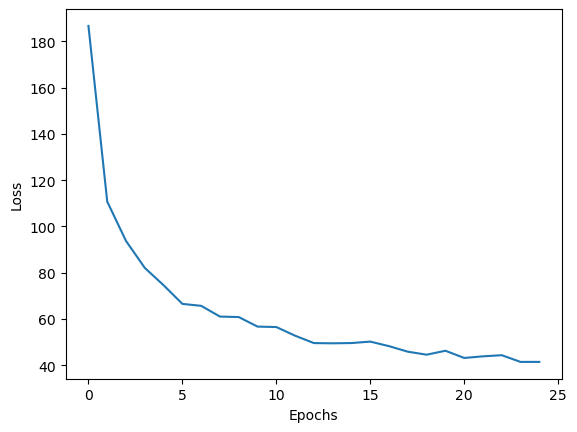

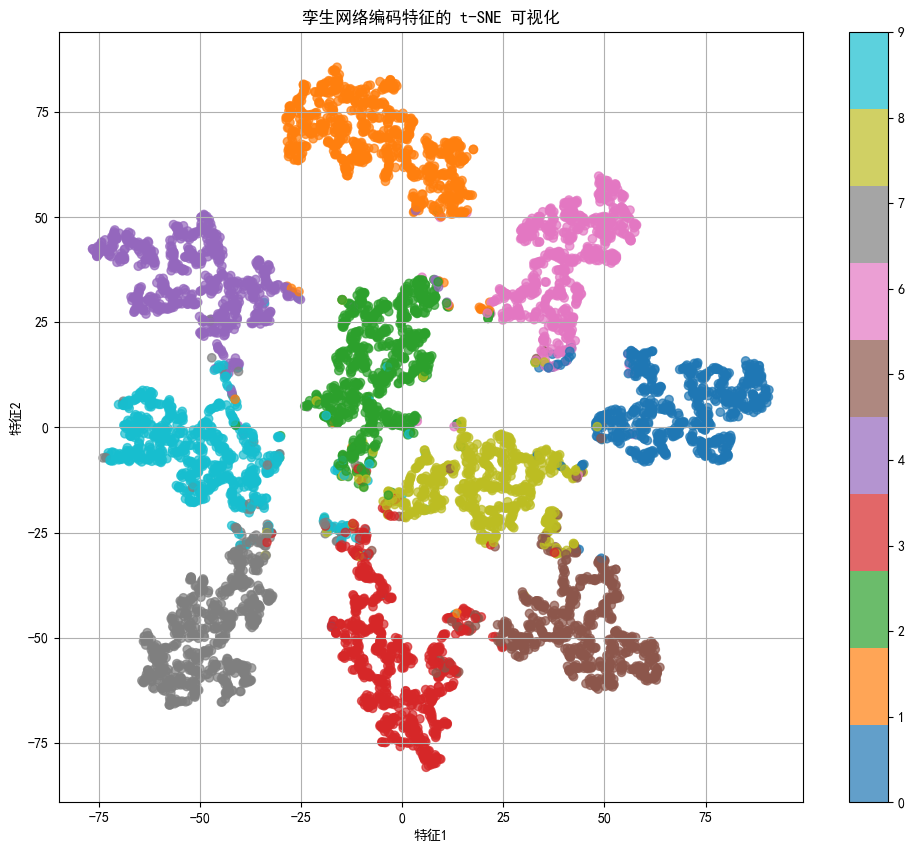

In [22]:
print('===========Siamese===========')
model = Siamese(output_size=10)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train(model, train_loader, optimizer, epochs, device)
# torch.save(model, '实现了一个卷积神经网络编码器部分，用于从输入图像中提取高维特征表示')
eval(model, device, test_loader, epochs)

在置空损失函数列表后，对自动编码器的编码器部分进行训练。训练中使用到的超参数同孪生网络训练中超参数一致。

===========AutoEDcoder===========
epoch:1 total_loss:215.18120235204697
epoch:2 total_loss:106.27425082027912
epoch:3 total_loss:87.39920969307423
epoch:4 total_loss:74.90183155238628
epoch:5 total_loss:69.8252719938755
epoch:6 total_loss:67.46279756724834
epoch:7 total_loss:64.70092578232288
epoch:8 total_loss:61.640875704586506
epoch:9 total_loss:59.145490162074566
epoch:10 total_loss:57.90655191242695
epoch:11 total_loss:55.83597306162119
epoch:12 total_loss:56.02646245062351
epoch:13 total_loss:54.08029295504093
epoch:14 total_loss:53.716400884091854
epoch:15 total_loss:53.495839558541775
epoch:16 total_loss:52.51711818575859
epoch:17 total_loss:51.148558028042316
epoch:18 total_loss:51.13220335543156
epoch:19 total_loss:49.66508858650923
epoch:20 total_loss:49.16161887720227
epoch:21 total_loss:48.80261316895485
epoch:22 total_loss:48.4839929677546
epoch:23 total_loss:48.19671607762575
epoch:24 total_loss:46.67500149458647
epoch:25 total_loss:48.139728758484125


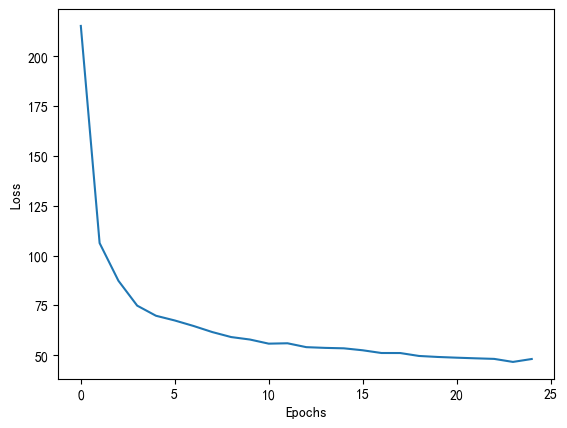

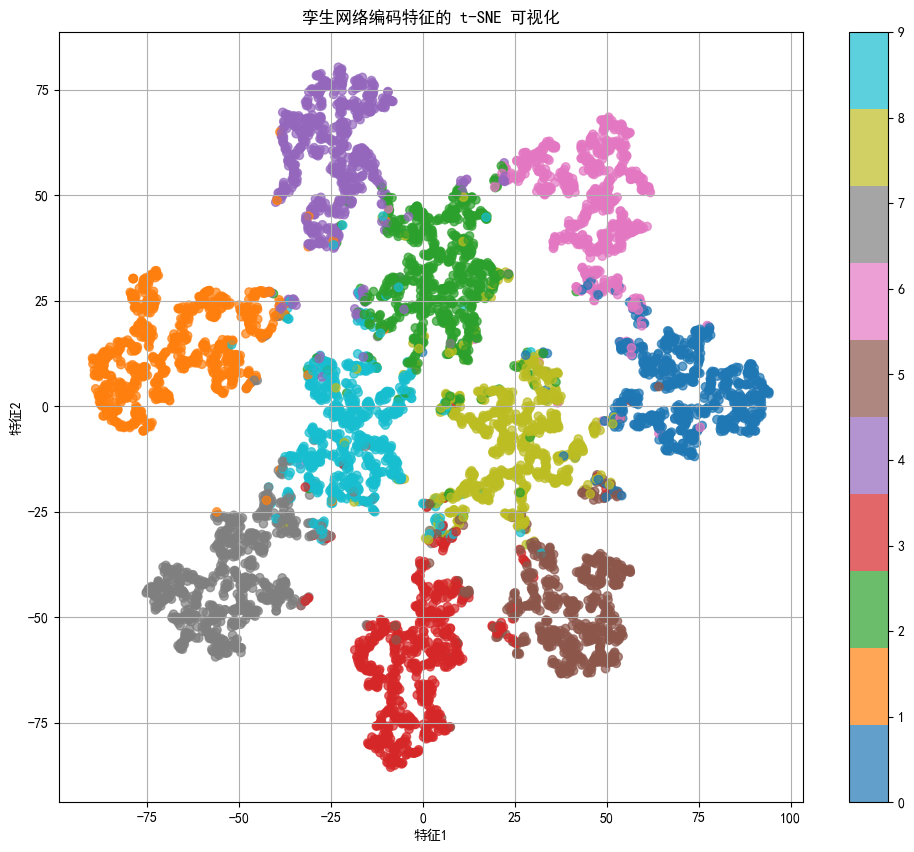

In [23]:
loss_list = []
net = AutoEDcoder()
print('===========AutoEDcoder===========')
trainer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train(net, train_loader, trainer, epochs, device)
eval(net, device, test_loader, epochs)